# Section 3.5 Practical course material 2: Robust portfolio optimization via Tyler estimator

This page contains simulations in Section 3.5 Practical course material 2

## Contents

    - Random equivalent asymptotics between $\hat C$ and $\hat S$
    - Portfolio risk, the asymptotic approximation $\sigma^2(\gamma)$, and the estimate $\hat \sigma^2(\gamma)$ versus the regularization $\gamma$

## Random equivalent asymptotics between $\hat C$ and $\hat S$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
pi = np.pi

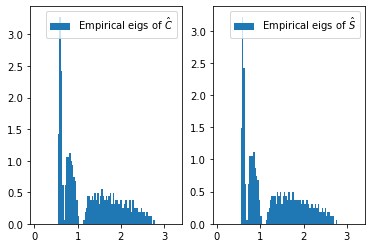

In [7]:
coeff = 5
p = 100*coeff
n = 500*coeff
c = p/n

np.random.seed(928)
eigs_C = np.concatenate([np.ones(p//4),3*np.ones(p//4),10*np.ones(p//2)])
C = np.diag(eigs_C) # population covariance
tau = np.random.gamma(.5,2,n)

Z = np.random.randn(p,n)
C_half = scipy.linalg.sqrtm(C)
X = C_half@Z@np.diag(np.sqrt(tau))

gamma = 0.5
if (gamma <= np.max([0,1-1/c]) or gamma >1):
    print('Error: wrong regularization gamma!')

hat_C_tmp = np.eye(p)
hat_C = np.eye(p)/2
while np.linalg.norm(hat_C-hat_C_tmp,2)/np.linalg.norm(hat_C,2)>1e-3:
    hat_C_tmp = hat_C
    hat_C = (1-gamma)*X@np.diag(1/np.diag(X.T@np.linalg.solve(hat_C,X)/p))@(X.T)/n + gamma*np.eye(p)

eigs_hat_C = np.linalg.eig(hat_C)[0]

delta = 1
delta_tmp = 0
while np.abs(delta-delta_tmp)>1e-6:
    delta_tmp = delta
    delta = np.mean( eigs_C/( (1-gamma)/delta*eigs_C + gamma ) )

hat_S = (1-gamma)/( 1-(1-gamma)*c )/delta*C_half@(Z@Z.T)@C_half/n + gamma*np.eye(p)
eigs_hat_S = np.linalg.eig(hat_S)[0]

edges=np.linspace(np.min(eigs_hat_C)-.5,np.max(eigs_hat_C)+.5,100)
plt.subplot(1,2,1)
plt.hist(eigs_hat_C,bins=edges,weights=1/p/(edges[1]-edges[0])*np.ones(len(eigs_hat_C)),label=r'Empirical eigs of $\hat C$')
_ = plt.legend()

plt.subplot(1,2,2)
plt.hist(eigs_hat_S,bins=edges,weights=1/p/(edges[1]-edges[0])*np.ones(len(eigs_hat_S)),label=r'Empirical eigs of $\hat S$')
_ = plt.legend()

## Portfolio risk, the asymptotic approximation $\sigma^2(\gamma)$, and the estimate $\hat \sigma^2(\gamma)$ versus the regularization $\gamma$

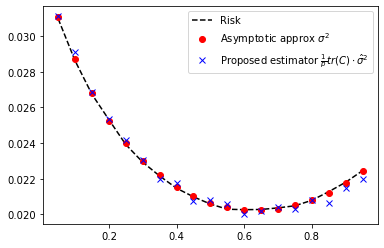

In [46]:
coeff = 1
p = 256*coeff
n = 512*coeff
c = p/n

np.random.seed(928)
u = (.5+ np.random.rand(p,1))/np.sqrt(p)
C = 5*u@u.T + np.eye(p)
eigs_C = np.linalg.eigh(C)[0]

gamma_loop = np.arange(0.05,1,0.05)
nb_average_loop = 50

store_output = []
for gamma in gamma_loop:

    if (gamma <= np.max([0,1-1/c]) or gamma >1):
        print('Error: wrong regularization gamma!')

    tmp = np.zeros( (1,3) )
    for average_loop in range(nb_average_loop):
        nu_student = 100 # degrees of freedom nu of Student's t distribution
        Z = np.random.standard_t(nu_student,(p,n))/np.sqrt(nu_student/(nu_student-2))

        d = 3
        tau = np.random.chisquare(d,n)/d

        C_half=scipy.linalg.sqrtm(C)
        X = C_half@Z@np.diag(np.sqrt(tau))

        hat_C_tmp = np.eye(p)
        hat_C = np.eye(p)/2
        while np.linalg.norm(hat_C-hat_C_tmp,2)/np.linalg.norm(hat_C,2)>1e-4:
            hat_C_tmp = hat_C
            hat_C = (1-gamma)*X@np.diag(1/np.diag(X.T@np.linalg.solve(hat_C,X)/p))@X.T/n + gamma*np.eye(p)

        eigs_hat_C = np.real(np.linalg.eigh(hat_C)[0])

        delta = 1
        delta_tmp = 0
        while np.abs(delta-delta_tmp)>1e-6:
            delta_tmp = delta

            delta = np.mean( eigs_C/( (1-gamma)/delta*eigs_C + gamma ) )

        hat_S = (1-gamma)/( 1-(1-gamma)*c )/delta*C_half@(Z@Z.T)@C_half/n + gamma*np.eye(p)
        eigs_hat_S = np.real(np.linalg.eigh(hat_S)[0])

        inv_hat_C_1 = np.linalg.solve(hat_C,np.ones(p))
        inv_hat_C_X = np.linalg.solve(hat_C,X)
        risk = inv_hat_C_1.T@C@inv_hat_C_1/np.sum(inv_hat_C_1)**2

        beta = np.mean( eigs_C**2/( (1-gamma)/delta*eigs_C + gamma )**2 )
        inv_eq_hat_C_1 = np.linalg.solve((1-gamma)/delta*C + gamma*np.eye(p),np.ones(p))
        sigma2 = delta**2/(delta**2-c*beta*(1-gamma)**2)*(inv_eq_hat_C_1.T@C@inv_eq_hat_C_1)/np.sum(inv_eq_hat_C_1)**2

        hat_delta = np.mean( np.diag(X.T@inv_hat_C_X)/np.diag(X.T@X) )/(1-(1-gamma)*c)
        hat_sigma2 = hat_delta/(1-gamma-(1-gamma)**2*c)*(inv_hat_C_1.T@(hat_C - gamma*np.eye(p))@inv_hat_C_1)/np.sum(inv_hat_C_1)**2

        tmp+= np.real(np.array([risk, sigma2, hat_sigma2*np.mean(eigs_C)]))/nb_average_loop

    store_output.append(tmp)

plt.plot(gamma_loop,[store_output[i][0][0] for i in range(len(gamma_loop))],'k--',label='Risk')
plt.plot(gamma_loop,[store_output[i][0][1] for i in range(len(gamma_loop))],'ro',label=r'Asymptotic approx $\sigma^2$')
plt.plot(gamma_loop,[store_output[i][0][2] for i in range(len(gamma_loop))],'bx',label=r'Proposed estimator $\frac{1}{p} tr(C) \cdot \hat \sigma^2$')
_ = plt.legend()